<center><h2>ALTeGraD 2024<br>Lab Session 2: Transfer learning for NLP</h2> 15 / 10 / 2024<br> Dr. G. Shang, Y. Zhang<br><br>


<b>Student name:</b> [Martin Jolif]

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 22, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [16]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [17]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, nhid, dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src) #fill me
        output = self.transformer_encoder(src, src_mask) #fill me
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)  #fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base.forward(src, src_mask) #fill me
        # classifier model
        output = self.classifier.forward(x) #fill me
        return output

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [19]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


**It's seems to be the right shape! We have a dummy_input of size 6 and a vocabulary size of 100 and get a $6*100$ matrix**

## Vocabulary and Tokenization

In [20]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 data/dict.txt

▁d 1
es 1
▁l 1
en 1
on 1


In [21]:
path_vocab = "data/dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
#sos for start of sequence, eos: end of sequence, oov: out of vocabulary
#pad: a special token used to fill in the extra spaces for shorter sequences to match the length of the longest sequence in a batch
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4 #fill me because the first 4 index are for special tokens

ind2token = {value:key for (key,value) in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [22]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        #fill me (construct the input sequence using token2ind, sequence and special tokens)
        end_source_sequence = []
        for word in sequence:
            if word in token2ind.keys():
                end_source_sequence.append(self.token2ind[word])
            else:
                end_source_sequence.append(self.token2ind['<oov>'])
        source_sequence = [self.token2ind["<sos>"]] + end_source_sequence 
        #end of fill me
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [23]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        #print('output shape:', output.shape)
        if task == 'classification':
            #last vector only
            output = output[-1] #fill me
        output = output.view(-1, output.shape[-1])
        target = data[1] #fill me
        target = target.to(device)
        loss =  criterion(output, target) #fill me, Cross entropy check next cells
        #fill me step 3 : Compute the loss through back-propagation
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4 : update the parameters of your model using sgd
        optimizer.step()
        
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [24]:
ntokens = len(token2ind)#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "data/pretraining_subset.txt"

In [57]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task= 'language_modeling', # fill me : because it's pretraining we give 'language_modeling'
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 6.83836 | ppl  932.955
| epoch   1 |  1000/ 3125 steps | loss 6.38794 | ppl  594.628
| epoch   1 |  1500/ 3125 steps | loss 6.15167 | ppl  469.500
| epoch   1 |  2000/ 3125 steps | loss 6.03120 | ppl  416.215
| epoch   1 |  2500/ 3125 steps | loss 5.95827 | ppl  386.938
| epoch   1 |  3000/ 3125 steps | loss 5.83204 | ppl  341.055
| epoch   2 |   500/ 3125 steps | loss 5.54974 | ppl  257.171
| epoch   2 |  1000/ 3125 steps | loss 5.52550 | ppl  251.011
| epoch   2 |  1500/ 3125 steps | loss 5.51741 | ppl  248.990
| epoch   2 |  2000/ 3125 steps | loss 5.47603 | ppl  238.897
| epoch   2 |  2500/ 3125 steps | loss 5.44133 | ppl  230.748
| epoch   2 |  3000/ 3125 steps | loss 5.42403 | ppl  226.792


## Text Generation


In [33]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt', weights_only=False, map_location=device)
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [34]:
# !pip install sentencepiece   # uncomment this if you are using google colab
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [35]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1]).item() #fill me
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    # I suppose max_len is corresponding to the max length of tokens generated
    # to be implemented
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    while len(sent_pieces) < max_len:
        sent_pieces = s.encode_as_pieces(sent)
        next_token_ind, _ = infer_next_token(s.decode_pieces(sent_pieces))
        if ind2token[next_token_ind] == '<eos>':
            break
        sent = sent + ind2token[next_token_ind].replace("▁", " ")
        
    print(sent)

In [54]:
sent = "Bonjour les"
infer_next_tokens(sent)

Bonjour les gens qui ont été très accueillants et sympathiques.


### Supervised task

In [108]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "data/train.review.spm"
path_labels_train = "data/train.label"

path_data_valid = "data/test.review.spm"
path_labels_valid = "data/test.label"

--2024-10-18 16:23:35--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.1s    

2024-10-18 16:23:36 (11.5 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2024-10-18 16:23:36--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

In [109]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    model.eval()
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
            input = data[0].to(device)
            output = model(input, src_mask) 
            predictions = torch.argmax(output[-1], dim = 1)
            # total number of examples
            ntotal += predictions.shape[0]
            # number of correct predictions 
            ncorrect += torch.sum(data[1].to(device) == predictions) 
        acc = ncorrect.item() / ntotal
        print("validation accuracy: {:3.2f}".format(acc*100))
        return acc    

In [110]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [111]:
if not torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("mps")

In [112]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.77137 | ppl    2.163
| epoch   1 |   100/  200 steps | loss 0.72268 | ppl    2.060
| epoch   1 |   150/  200 steps | loss 0.71708 | ppl    2.048
validation accuracy: 54.55
| epoch   2 |    50/  200 steps | loss 0.68052 | ppl    1.975
| epoch   2 |   100/  200 steps | loss 0.59233 | ppl    1.808
| epoch   2 |   150/  200 steps | loss 0.64922 | ppl    1.914
validation accuracy: 69.50
| epoch   3 |    50/  200 steps | loss 0.52279 | ppl    1.687
| epoch   3 |   100/  200 steps | loss 0.47346 | ppl    1.606
| epoch   3 |   150/  200 steps | loss 0.41768 | ppl    1.518
validation accuracy: 74.70
| epoch   4 |    50/  200 steps | loss 0.22998 | ppl    1.259
| epoch   4 |   100/  200 steps | loss 0.29779 | ppl    1.347
| epoch   4 |   150/  200 steps | loss 0.29979 | ppl    1.350
validation accuracy: 74.75
| epoch   5 |    50/  200 steps | loss 0.09449 | ppl    1.099
| epoch   5 |   100/  200 steps | loss 0.07928 | ppl  

/var/folders/m9/xmtphkx904b8hxdxrgm2jnz80000gn/T/ipykernel_6099/2078304511.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4la

| epoch   1 |    50/  200 steps | loss 0.74223 | ppl    2.101
| epoch   1 |   100/  200 steps | loss 0.67145 | ppl    1.957
| epoch   1 |   150/  200 steps | loss 0.58419 | ppl    1.794
validation accuracy: 76.65
| epoch   2 |    50/  200 steps | loss 0.52979 | ppl    1.699
| epoch   2 |   100/  200 steps | loss 0.48223 | ppl    1.620
| epoch   2 |   150/  200 steps | loss 0.48982 | ppl    1.632
validation accuracy: 77.95
| epoch   3 |    50/  200 steps | loss 0.37942 | ppl    1.461
| epoch   3 |   100/  200 steps | loss 0.36930 | ppl    1.447
| epoch   3 |   150/  200 steps | loss 0.44337 | ppl    1.558
validation accuracy: 77.75
| epoch   4 |    50/  200 steps | loss 0.34607 | ppl    1.414
| epoch   4 |   100/  200 steps | loss 0.30556 | ppl    1.357
| epoch   4 |   150/  200 steps | loss 0.34617 | ppl    1.414
validation accuracy: 79.25
| epoch   5 |    50/  200 steps | loss 0.29786 | ppl    1.347
| epoch   5 |   100/  200 steps | loss 0.28668 | ppl    1.332
| epoch   5 |   150/  20

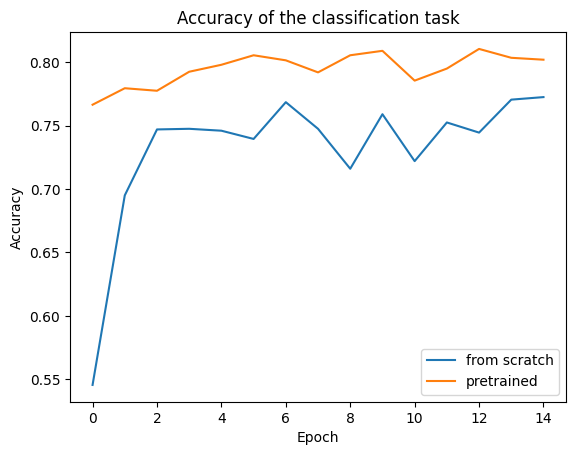

In [113]:
#Visualize the accuracy

import matplotlib.pyplot as plt

plt.plot([acc for acc in from_scratch_valid_acc], label="from scratch")
plt.plot([acc for acc in pretrained_valid_acc], label="pretrained")
plt.title("Accuracy of the classification task")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_vs_scratch.png")

### Number of paramters of a model

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
ntokens = len(token2ind)#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

##### Language-modeling task

In [26]:
model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [29]:
count_parameters(model)

21018401

##### Classification task (positive/negative) from scratch

In [30]:
model = Model(ntokens, nhead, nhid, nlayers, nclasses, dropout).to(device)

In [31]:
count_parameters(model)

10968602